In [49]:
import pyspark
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, FloatType
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import *


In [50]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Vehicle Analysis") \
    .getOrCreate()

In [51]:
# Load the CSV file into a DataFrame
df = spark.read.load(r'C:\Users\S559283\Downloads\csis-dspython\csis-dspython-master\Electric_Vehicle_Population_Data.csv', format='csv', sep=',', header='true', escape='"', inferSchema=True)


In [52]:
df.count()

177866

In [53]:
# Show the DataFrame schema
df.printSchema()

root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: integer (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)



In [54]:
df.show()

+----------+---------+-----------------+-----+-----------+----------+---------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|VIN (1-10)|   County|             City|State|Postal Code|Model Year|     Make|  Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|
+----------+---------+-----------------+-----+-----------+----------+---------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|5YJYGDEE1L|     King|          Seattle|   WA|      98122|      2020|    TESLA|MODEL Y| Battery Electric ...|                             Clean Alternative..

In [55]:
# Drop rows with missing values
cleaned_df = df.dropna()

# Convert columns to correct data types
cleaned_df = cleaned_df.withColumn("Model Year", cleaned_df["Model Year"].cast(IntegerType()))
cleaned_df = cleaned_df.withColumn("Electric Range", cleaned_df["Electric Range"].cast(FloatType()))

# Remove duplicate rows
cleaned_df = cleaned_df.dropDuplicates()

# Drop outliers in 'Electric Range' column
# Assuming outliers are values below 0 or above 1000
cleaned_df = cleaned_df.filter((col("Electric Range") >= 0) & (col("Electric Range") <= 1000))

# Normalize 'Electric Range' column
max_range = cleaned_df.agg({"Electric Range": "max"}).collect()[0][0]
cleaned_df = cleaned_df.withColumn("Normalized Electric Range", cleaned_df["Electric Range"] / max_range)

# Parse 'Vehicle Location' into separate columns
cleaned_df = cleaned_df.withColumn("Latitude", split(col("Vehicle Location"), " ")[1].cast(FloatType()))
cleaned_df = cleaned_df.withColumn("Longitude", split(col("Vehicle Location"), " ")[2].cast(FloatType()))

# Convert 'Clean Alternative Fuel Vehicle (CAFV) Eligibility' to boolean
cleaned_df = cleaned_df.withColumn("CAFV Eligibility", col("Clean Alternative Fuel Vehicle (CAFV) Eligibility") == "Clean Alternative Fuel Vehicle Eligible")

# Drop 'Clean Alternative Fuel Vehicle (CAFV) Eligibility' column
cleaned_df = cleaned_df.drop("Clean Alternative Fuel Vehicle (CAFV) Eligibility")



In [56]:
# Show the cleaned DataFrame schema
cleaned_df.printSchema()



root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Electric Range: float (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: integer (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)
 |-- Normalized Electric Range: double (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- CAFV Eligibility: boolean (nullable = true)



In [57]:


# Show the first few rows of the cleaned DataFrame
cleaned_df.show()

+----------+--------+-----------------+-----+-----------+----------+----------+--------------+---------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+-------------------------+--------+---------+----------------+
|VIN (1-10)|  County|             City|State|Postal Code|Model Year|      Make|         Model|Electric Vehicle Type|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|Normalized Electric Range|Latitude|Longitude|CAFV Eligibility|
+----------+--------+-----------------+-----+-----------+----------+----------+--------------+---------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+-------------------------+--------+---------+----------------+
|1C4JJXP61M|Thurston|           Tenino|   WA|      98589|      2021|      JEEP|      WRANGLER| Plug-

In [58]:
updated_df = df.withColumn("Latitude", lit(47.6062).cast("float")) \
               .withColumn("Longitude", lit(-122.3321).cast("float"))


In [59]:
df.show()

+----------+---------+-----------------+-----+-----------+----------+---------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|VIN (1-10)|   County|             City|State|Postal Code|Model Year|     Make|  Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|
+----------+---------+-----------------+-----+-----------+----------+---------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|5YJYGDEE1L|     King|          Seattle|   WA|      98122|      2020|    TESLA|MODEL Y| Battery Electric ...|                             Clean Alternative..

In [60]:
# Check for null values in each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])



In [61]:


# Show the counts of null values
null_counts.show()

+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|VIN (1-10)|County|City|State|Postal Code|Model Year|Make|Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|Vehicle Location|Electric Utility|2020 Census Tract|
+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|         0|     5|   5|    0|          5|         0|   0|    0|                    0|                                                0|             0|        0|                 389|             0|               9|               5|                5|


In [62]:
# Remove rows with null values
cleaned_df = df.dropna()

# Show the cleaned DataFrame
cleaned_df.show()


+----------+---------+-----------------+-----+-----------+----------+---------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|VIN (1-10)|   County|             City|State|Postal Code|Model Year|     Make|  Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|
+----------+---------+-----------------+-----+-----------+----------+---------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|5YJYGDEE1L|     King|          Seattle|   WA|      98122|      2020|    TESLA|MODEL Y| Battery Electric ...|                             Clean Alternative..

In [63]:
# Remove rows with null values in specific columns
cleaned_df = df.dropna(subset=["County", "City", "Postal Code", "Legislative District", "Vehicle Location", "Electric Utility", "2020 Census Tract"])

# Show the cleaned DataFrame
cleaned_df.show()


+----------+---------+-----------------+-----+-----------+----------+---------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|VIN (1-10)|   County|             City|State|Postal Code|Model Year|     Make|  Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|
+----------+---------+-----------------+-----+-----------+----------+---------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|5YJYGDEE1L|     King|          Seattle|   WA|      98122|      2020|    TESLA|MODEL Y| Battery Electric ...|                             Clean Alternative..

In [64]:
# Check for null values in each column of the cleaned DataFrame
null_counts_cleaned = cleaned_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in cleaned_df.columns])

# Show the counts of null values in the cleaned DataFrame
null_counts_cleaned.show()

+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|VIN (1-10)|County|City|State|Postal Code|Model Year|Make|Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|Vehicle Location|Electric Utility|2020 Census Tract|
+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|         0|     0|   0|    0|          0|         0|   0|    0|                    0|                                                0|             0|        0|                   0|             0|               0|               0|                0|


+--------------+------------------+----+------+------+
|   Column_Name|              Mean| Min|   Max|Median|
+--------------+------------------+----+------+------+
|    Model Year|2020.5171152795074|1997|  2024|  2022|
|Electric Range| 58.82654826367955|   0|   337|     0|
|     Base MSRP|1070.6098392431525|   0|845000|     0|
+--------------+------------------+----+------+------+



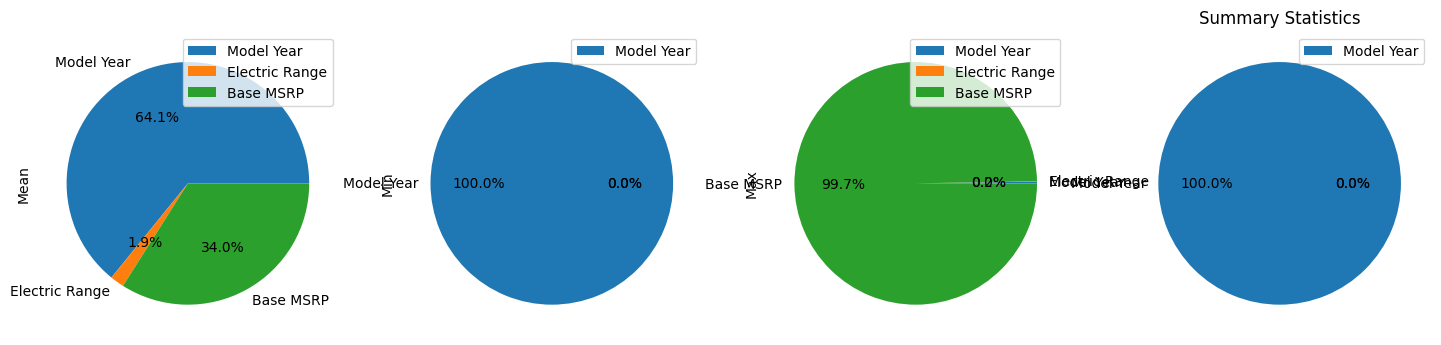

In [65]:
# Register the DataFrame as a temporary table
cleaned_df.createOrReplaceTempView("electric_vehicles")

# Define the SQL query to calculate summary statistics
sql_query = """
SELECT
    'Model Year' AS Column_Name,
    AVG(`Model Year`) AS Mean,
    MIN(`Model Year`) AS Min,
    MAX(`Model Year`) AS Max,
    percentile_approx(`Model Year`, 0.5) AS Median
FROM
    electric_vehicles

UNION ALL

SELECT
    'Electric Range' AS Column_Name,
    AVG(`Electric Range`) AS Mean,
    MIN(`Electric Range`) AS Min,
    MAX(`Electric Range`) AS Max,
    percentile_approx(`Electric Range`, 0.5) AS Median
FROM
    electric_vehicles

UNION ALL

SELECT
    'Base MSRP' AS Column_Name,
    AVG(`Base MSRP`) AS Mean,
    MIN(`Base MSRP`) AS Min,
    MAX(`Base MSRP`) AS Max,
    percentile_approx(`Base MSRP`, 0.5) AS Median
FROM
    electric_vehicles
"""

# Run the SQL query to calculate summary statistics
summary_stats = spark.sql(sql_query)

# Show the summary statistics table
summary_stats.show()

import matplotlib.pyplot as plt
import pandas as pd

# Convert the result to a pandas DataFrame
summary_stats_pd = summary_stats.toPandas()

# Set the 'Column_Name' column as the index
summary_stats_pd.set_index('Column_Name', inplace=True)

# Plotting the summary statistics as a pie chart
summary_stats_pd.plot(kind='pie', subplots=True, figsize=(18, 12), autopct='%1.1f%%')
plt.ylabel('')
plt.title('Summary Statistics')
plt.show()


+-----------------+-----------------+
|             City|Num_Electric_Cars|
+-----------------+-----------------+
|           Bingen|                7|
|          Edmonds|             1896|
|         Tumwater|              639|
|           Auburn|             1897|
|           Sultan|              173|
|           Monroe|              765|
|         Woodland|              175|
|Bainbridge Island|             1760|
|          Bothell|             5863|
|          Kenmore|             1028|
|          Cowiche|                5|
|          Everett|             2475|
|        Snohomish|             2102|
|    Normandy Park|              269|
|       Coupeville|              228|
|       Silverlake|               32|
|        Indianola|               61|
|        Wenatchee|              412|
|       Mill Creek|              695|
|           Olalla|               97|
+-----------------+-----------------+
only showing top 20 rows



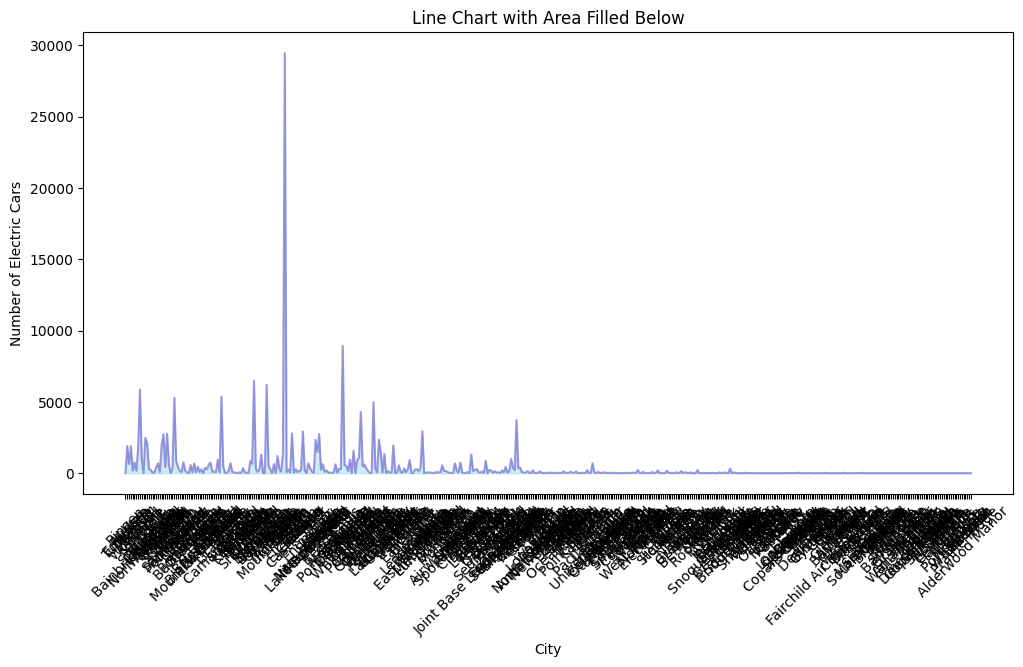

In [72]:
# Define the SQL query to count electric cars by city
count_by_city_query = """
SELECT
    City,
    COUNT(*) AS Num_Electric_Cars
FROM
    electric_vehicles
GROUP BY
    City
"""

# Run the SQL query to count electric cars by city
count_by_city_df = spark.sql(count_by_city_query)

# Show the result
count_by_city_df.show()

import matplotlib.pyplot as plt

# Assuming count_by_city_df is a Pandas DataFrame
count_by_city_pd_df = count_by_city_df.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(count_by_city_pd['City'], count_by_city_pd['Num_Electric_Cars'], color="Slateblue", alpha=0.6)
plt.fill_between(count_by_city_pd['City'], count_by_city_pd['Num_Electric_Cars'], color="skyblue", alpha=0.4)
plt.xlabel('City')
plt.ylabel('Number of Electric Cars')
plt.title('Line Chart with Area Filled Below')
plt.xticks(rotation=45)
plt.show()

+-----------------+-----------------+
|             City|Num_Electric_Cars|
+-----------------+-----------------+
|           Bingen|                7|
|          Edmonds|             1896|
|         Tumwater|              639|
|           Auburn|             1897|
|           Sultan|              173|
|           Monroe|              765|
|         Woodland|              175|
|Bainbridge Island|             1760|
|          Bothell|             5863|
|          Kenmore|             1028|
|          Cowiche|                5|
|          Everett|             2475|
|        Snohomish|             2102|
|    Normandy Park|              269|
|       Coupeville|              228|
|       Silverlake|               32|
|        Indianola|               61|
|        Wenatchee|              412|
|       Mill Creek|              695|
|           Olalla|               97|
+-----------------+-----------------+
only showing top 20 rows



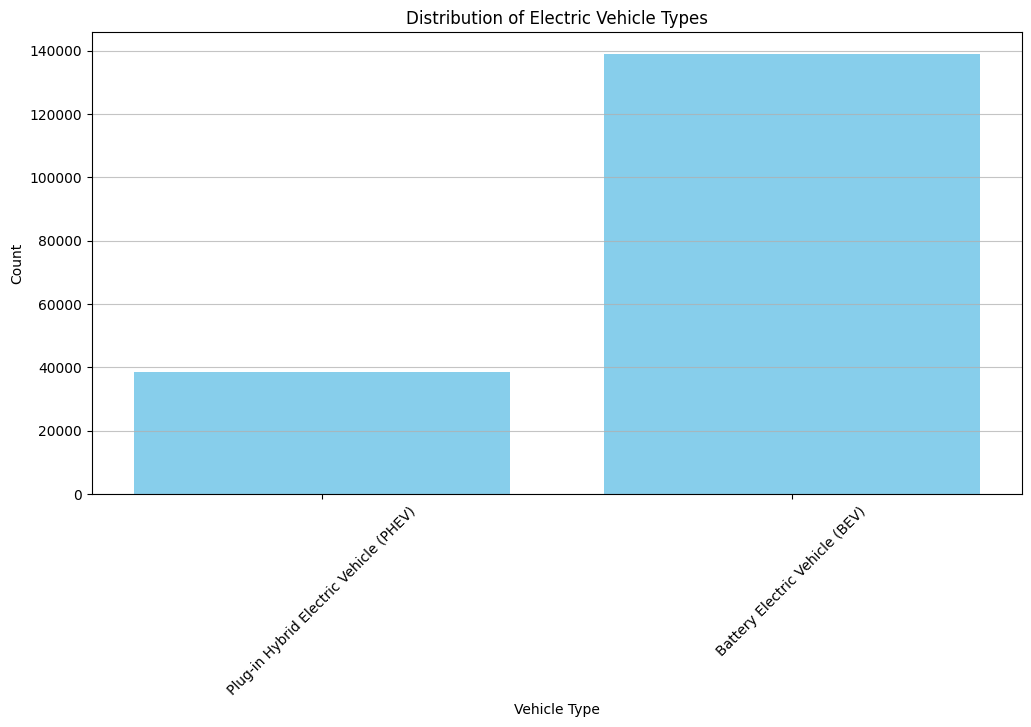

In [74]:
# Define the SQL query to calculate the distribution of electric vehicle types
vehicle_type_distribution_query = """
SELECT
    `Electric Vehicle Type` AS Vehicle_Type,
    COUNT(*) AS Count
FROM
    electric_vehicles
GROUP BY
    `Electric Vehicle Type`
"""

# Run the SQL query to calculate the distribution of electric vehicle types
vehicle_type_distribution_df = spark.sql(vehicle_type_distribution_query)

# Show the result
count_by_city_df.show()

# Convert the result to a pandas DataFrame for easier plotting
vehicle_type_distribution_pd = vehicle_type_distribution_df.toPandas()

import matplotlib.pyplot as plt

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(vehicle_type_distribution_pd['Vehicle_Type'], vehicle_type_distribution_pd['Count'], color='skyblue')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.title('Distribution of Electric Vehicle Types')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()


+--------------------+-----------------+
|Regulations_Category|Num_Electric_Cars|
+--------------------+-----------------+
|      No Regulations|           177473|
+--------------------+-----------------+



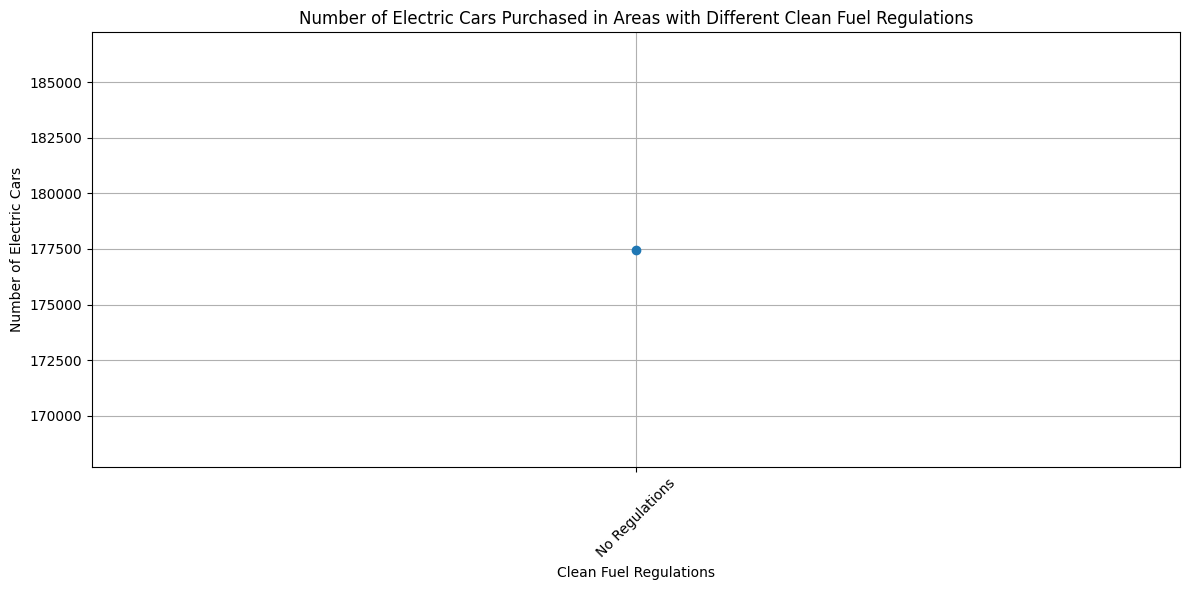

In [75]:
# Define the SQL query to calculate the number of electric cars purchased in areas with different clean fuel regulations
fuel_regulations_analysis_query = """
SELECT
    CASE
        WHEN `Clean Alternative Fuel Vehicle (CAFV) Eligibility` = 'Strict' THEN 'Strict Regulations'
        WHEN `Clean Alternative Fuel Vehicle (CAFV) Eligibility` = 'Moderate' THEN 'Moderate Regulations'
        ELSE 'No Regulations'
    END AS Regulations_Category,
    COUNT(*) AS Num_Electric_Cars
FROM
    electric_vehicles
GROUP BY
    Regulations_Category
"""

# Run the SQL query
fuel_regulations_analysis_df = spark.sql(fuel_regulations_analysis_query)

# Show the result
fuel_regulations_analysis_df.show()
import matplotlib.pyplot as plt

# Assuming fuel_regulations_analysis_df is a Spark DataFrame
# Convert the Spark DataFrame to a Pandas DataFrame for plotting
fuel_regulations_analysis_pd_df = fuel_regulations_analysis_df.toPandas()

# Create a line chart
plt.figure(figsize=(12, 6))
plt.plot(fuel_regulations_analysis_pd_df['Regulations_Category'], fuel_regulations_analysis_pd_df['Num_Electric_Cars'], marker='o')
plt.xlabel('Clean Fuel Regulations')
plt.ylabel('Number of Electric Cars')
plt.title('Number of Electric Cars Purchased in Areas with Different Clean Fuel Regulations')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


+---------+-----------------+------------------+
|     City|Num_Electric_Cars|        Percentage|
+---------+-----------------+------------------+
|  Seattle|            29447|16.592383066720007|
| Bellevue|             8930| 5.031751308649766|
|  Redmond|             6478|3.6501326962411187|
|Vancouver|             6193| 3.489544888518253|
|  Bothell|             5863|3.3036011111549364|
+---------+-----------------+------------------+

+-----------+-----------------+--------------------+
|       City|Num_Electric_Cars|          Percentage|
+-----------+-----------------+--------------------+
|Clallam Bay|                1|5.634659920100522E-4|
|     Bucoda|                1|5.634659920100522E-4|
|    Vantage|                1|5.634659920100522E-4|
|     Malott|                1|5.634659920100522E-4|
|   Kapowsin|                1|5.634659920100522E-4|
+-----------+-----------------+--------------------+



C:\Users\S559283\AppData\Local\Temp\ipykernel_19520\2059940028.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(location_analysis_pd_df['City'], rotation=45)


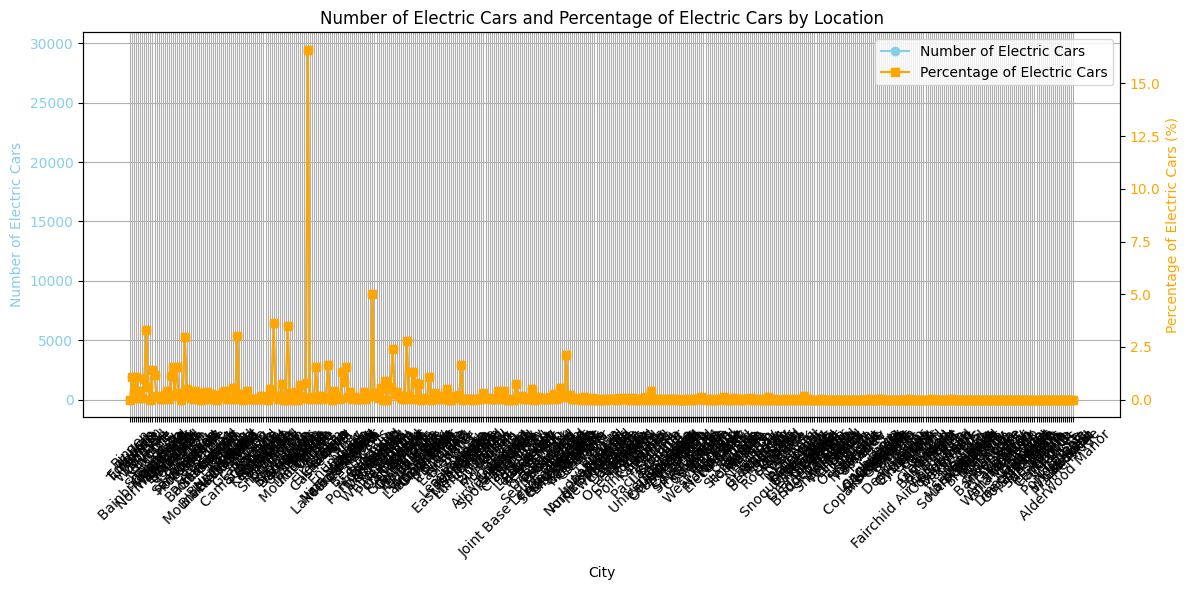

In [85]:
# Define the SQL query to calculate the number of electric cars by location
location_analysis_query = """
SELECT
    City,
    COUNT(*) AS Num_Electric_Cars
FROM
    electric_vehicles
GROUP BY
    City
"""

# Run the SQL query
location_analysis_df = spark.sql(location_analysis_query)

# Calculate the total number of electric cars
total_cars = location_analysis_df.agg({"Num_Electric_Cars": "sum"}).collect()[0][0]

# Normalize the counts
location_analysis_df = location_analysis_df.withColumn("Percentage", col("Num_Electric_Cars") / total_cars * 100)

# Identify popular and less popular locations
popular_locations = location_analysis_df.orderBy(col("Percentage").desc()).limit(5)
less_popular_locations = location_analysis_df.orderBy(col("Percentage")).limit(5)

# Show the results
popular_locations.show()
less_popular_locations.show()

import matplotlib.pyplot as plt

# Assuming location_analysis_df is a Spark DataFrame
# Convert the Spark DataFrame to a Pandas DataFrame for plotting
location_analysis_pd_df = location_analysis_df.toPandas()

# Normalize the counts
total_cars = location_analysis_pd_df['Num_Electric_Cars'].sum()
location_analysis_pd_df['Percentage'] = location_analysis_pd_df['Num_Electric_Cars'] / total_cars * 100

# Create a line chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the number of electric cars on the primary y-axis
ax1.plot(location_analysis_pd_df['City'], location_analysis_pd_df['Num_Electric_Cars'], color='skyblue', marker='o', label='Number of Electric Cars')
ax1.set_xlabel('City')
ax1.set_ylabel('Number of Electric Cars', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.grid(True)
ax1.set_xticklabels(location_analysis_pd_df['City'], rotation=45)

# Create a secondary y-axis for the percentage of electric cars
ax2 = ax1.twinx()
ax2.plot(location_analysis_pd_df['City'], location_analysis_pd_df['Percentage'], color='orange', marker='s', label='Percentage of Electric Cars')
ax2.set_ylabel('Percentage of Electric Cars (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Number of Electric Cars and Percentage of Electric Cars by Location')
plt.tight_layout()
plt.show()






+-------------+------------+
| Manufacturer|Num_Vehicles|
+-------------+------------+
|        TESLA|       79471|
|       NISSAN|       13984|
|    CHEVROLET|       13651|
|         FORD|        9177|
|          BMW|        7556|
|          KIA|        7423|
|       TOYOTA|        6254|
|   VOLKSWAGEN|        4993|
|         JEEP|        4468|
|      HYUNDAI|        4398|
|       RIVIAN|        4307|
|        VOLVO|        4124|
|         AUDI|        3637|
|     CHRYSLER|        2976|
|MERCEDES-BENZ|        1588|
|      PORSCHE|        1137|
|   MITSUBISHI|         957|
|         MINI|         898|
|     POLESTAR|         881|
|        HONDA|         831|
+-------------+------------+
only showing top 20 rows



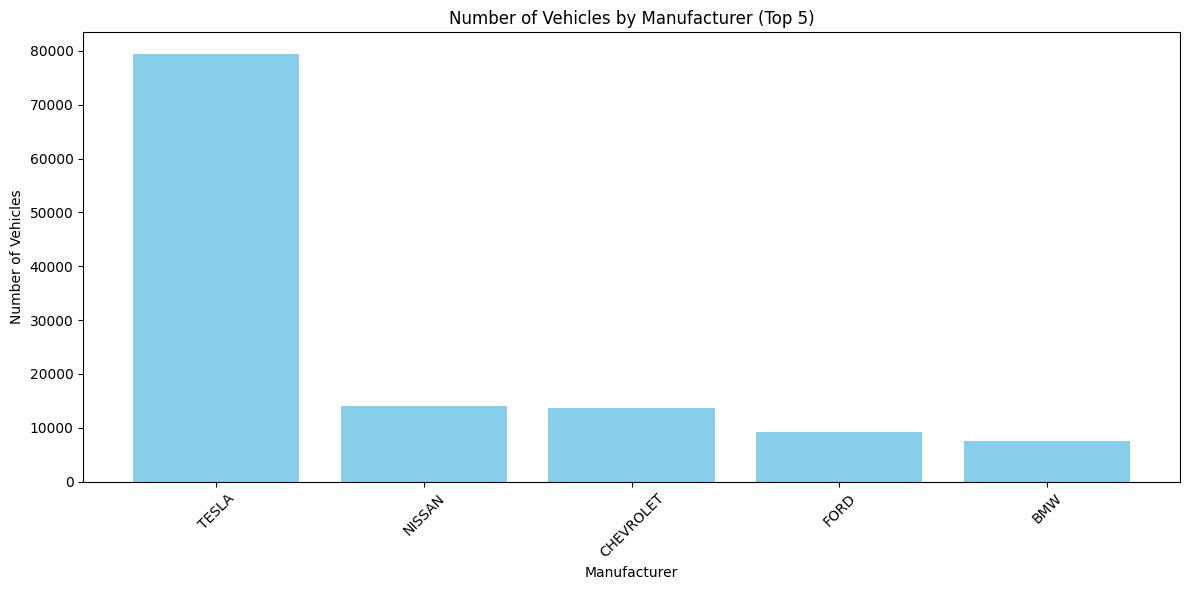

In [86]:
# Define the SQL query to calculate the number of vehicles for each manufacturer
manufacturer_analysis_query = """
SELECT
    Make AS Manufacturer,
    COUNT(*) AS Num_Vehicles
FROM
    electric_vehicles
GROUP BY
    Make
ORDER BY
    Num_Vehicles DESC
"""

# Run the SQL query
manufacturer_analysis_df = spark.sql(manufacturer_analysis_query)

# Show the top manufacturers
manufacturer_analysis_df.show() 

import matplotlib.pyplot as plt

# Assuming manufacturer_analysis_df is a Spark DataFrame
# Convert the Spark DataFrame to a Pandas DataFrame for plotting
manufacturer_analysis_pd_df = manufacturer_analysis_df.toPandas()

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(manufacturer_analysis_pd_df['Manufacturer'][:5], manufacturer_analysis_pd_df['Num_Vehicles'][:5], color='skyblue')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Vehicles')
plt.title('Number of Vehicles by Manufacturer (Top 5)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


+---------------+------------------+
|          Model|Avg_Electric_Range|
+---------------+------------------+
|EQE-CLASS SEDAN|               0.0|
|            S60|30.354609929078013|
|            EV9|               0.0|
|           740E|              14.0|
|    FLYING SPUR|              21.0|
|          FOCUS| 78.98712446351931|
|        SOUL EV| 98.06511627906977|
|        BOLT EV|154.85714285714286|
|           VOLT| 45.36511919698871|
|           KONA|             258.0|
|           330E|18.008830022075056|
|        CLARITY| 47.00852618757612|
|            PS2| 37.55505107832009|
|         SONATA|27.068493150684933|
|             I5|               0.0|
|          F-150|               0.0|
|       SPORTAGE|              34.0|
|             NX|              37.0|
|        IONIQ 5|               0.0|
|        AVIATOR|              21.0|
+---------------+------------------+
only showing top 20 rows



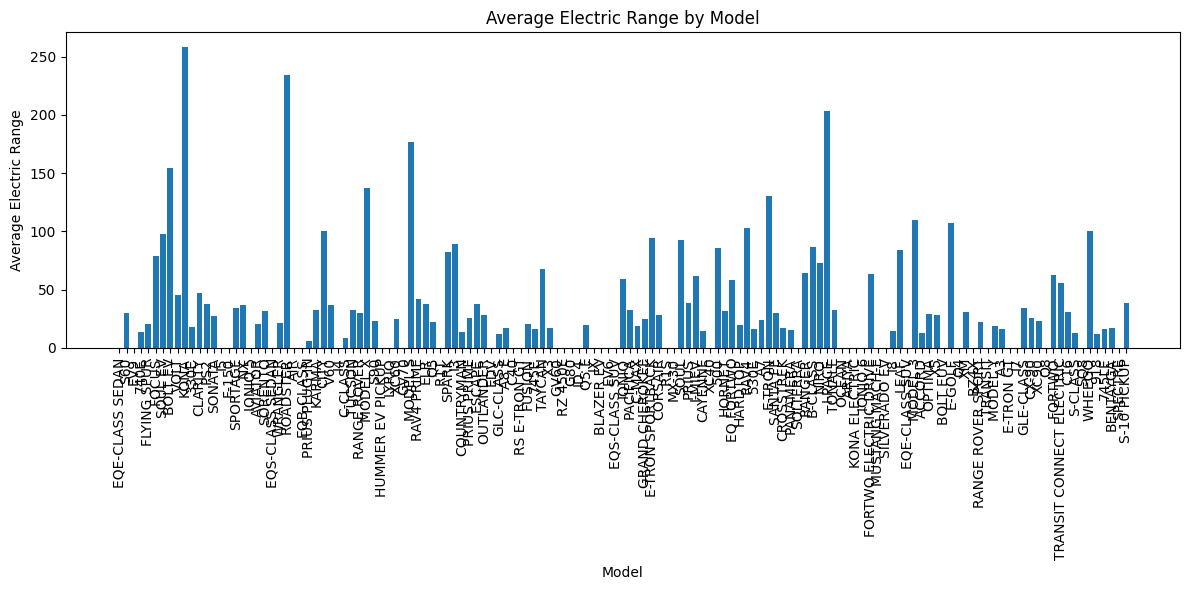

In [93]:
# SQL query to calculate average electric range by model
query = """
SELECT
    Model,
    AVG(`Electric Range`) AS Avg_Electric_Range
FROM
    electric_vehicles
GROUP BY
    Model
"""

# Execute the SQL query
range_analysis_df = spark.sql(query)

# Show the first few rows of the resulting DataFrame
range_analysis_df.show()
 

import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
range_analysis_pd_df = range_analysis_df.toPandas()

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range_analysis_pd_df['Model'], range_analysis_pd_df['Avg_Electric_Range'])
plt.xlabel('Model')
plt.ylabel('Average Electric Range')
plt.title('Average Electric Range by Model')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




+----------+------------------+------------------+
|Model_Year|     Avg_Base_MSRP|Avg_Electric_Range|
+----------+------------------+------------------+
|      1997|               0.0|              39.0|
|      1998|               0.0|              58.0|
|      1999|               0.0|              74.0|
|      2000|               0.0|              58.0|
|      2002|               0.0|              95.0|
|      2003|               0.0|              95.0|
|      2008|           98950.0|             220.0|
|      2010|100781.95652173914|226.08695652173913|
|      2011|  984.516129032258|  70.8916129032258|
|      2012| 5471.685254027261|61.172242874845104|
|      2013| 11552.01182086838| 79.82223232552853|
|      2014|12776.344393592677|  80.7983409610984|
|      2015|175.09324492333195| 98.25486945710733|
|      2016| 2305.714024501737|101.19711098921192|
|      2017|1085.3163815326927|114.16229200843684|
|      2018|2477.5090998180035| 156.1659666806664|
|      2019|1901.6374965637312|

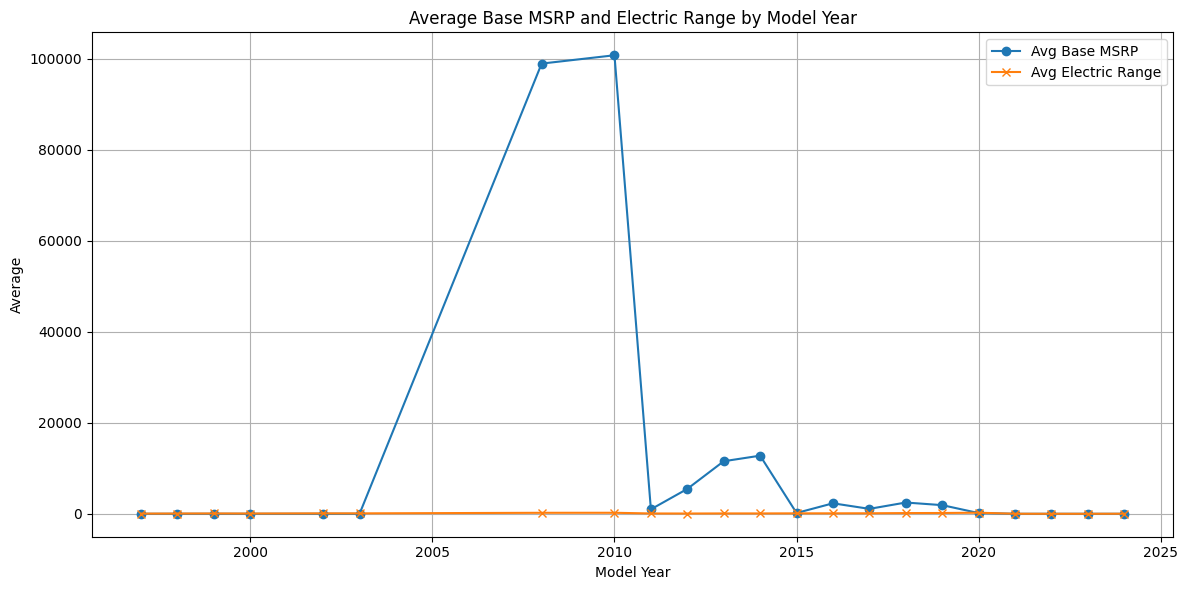

In [92]:
# SQL query to analyze the relationship between base MSRP, electric range, and model year
query = """
SELECT
    `Model Year` AS Model_Year,
    AVG(`Base MSRP`) AS Avg_Base_MSRP,
    AVG(`Electric Range`) AS Avg_Electric_Range
FROM
    electric_vehicles
GROUP BY
    `Model Year`
ORDER BY
    `Model Year`
"""

# Execute the SQL query
price_analysis_df = spark.sql(query)

# Show the first few rows of the resulting DataFrame
price_analysis_df.show()
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
price_analysis_pd_df = price_analysis_df.toPandas()

# Create a line chart
plt.figure(figsize=(12, 6))
plt.plot(price_analysis_pd_df['Model_Year'], price_analysis_pd_df['Avg_Base_MSRP'], marker='o', label='Avg Base MSRP')
plt.plot(price_analysis_pd_df['Model_Year'], price_analysis_pd_df['Avg_Electric_Range'], marker='x', label='Avg Electric Range')
plt.xlabel('Model Year')
plt.ylabel('Average')
plt.title('Average Base MSRP and Electric Range by Model Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
